# Model development and deployment

The approach to the creation of the model is to first create a data file with all the relevant information. This way, the information will be available at any time and it will not have to be calculated again. It will still be possible to train the model over a desired amount of seasons. The first step, is to create a dataframe and add the relevant information into it.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

train_df = pd.read_csv('../laliga.csv')

train_df["local_score"] = train_df["score"].str.split(":").str[0]
train_df["away_score"] = train_df["score"].str.split(":").str[1]
train_df['results'] = train_df.apply(lambda row: 1 if row['local_score'] > row['away_score'] else (2 if row['away_score'] > row['local_score'] else ('X' if row['local_score'] == row['away_score'] else None)), axis=1)
train_df['results_encoded'] = train_df.apply(lambda row: 1 if row['results'] == 1 else (3 if row['results'] == 2 else (2 if row['results'] == 'X' else None)), axis=1)

train_df = train_df.dropna(subset=['local_score'])
train_df = train_df.dropna(subset=['away_score'])
train_df['local_score'] = train_df['local_score'].astype(int)
train_df['away_score'] = train_df['away_score'].astype(int)
train_df['goal_diff'] = train_df['local_score'] - train_df['away_score']
train_df['abs_goal_diff'] = np.abs(train_df['goal_diff'])

The most important addition to the code is the creation of an Elo socre system. This system aims to quantify the strength of a team at a given point in time. It works like in chess, if a team wins or draws against a stronger team, its Elo score will increase, if it loses or draws against a weaker team it will decrease.

In [3]:
Elo_table = pd.DataFrame()
Elo_table['Team'] = train_df['home_team'].unique()
Elo_table['ELO'] = 1000

train_df['Local_Elo'] = 0
train_df['Away_Elo'] = 0
train_df['Elo_diff'] = 0

Also, we will provide a unique id to every team.

In [4]:
team_id = pd.DataFrame()
team_id['Team'] = train_df['home_team'].unique()
team_id['Id'] = team_id.index

Now we will define a funciton that calculates the Elo score for every team after every match and save it. This is done by having another table where the current Elo of a team will be stored, and accessing it when necessary. This Elo score file will end up with the current score for every team. It will be used to provide an Elo for the teams of the prediction.

In order to determine the Elo score, it is first necessary to calculate the expected result given one's score and an opponents score. It works in the following way:

$E_A = \frac{1}{1+10^{(R_B-R_A)/400}}$

Where E is the expected result for team A, R is the rating of the teams, being B the opponent team. You can see that if the rating is the same the expected result is $1/2$, which could be interpreted as having the same chance to win or a tie. After the result is known ($1$ for victory, $1/2$ for a tie and $0$ for a defeat), the rating of the team is adjused in the following way:

$R'_A = R_A + K(S_A-E_A)$

Where R' is the new rating and S is the result. K is factor that can be adjusted, in our case we have chosen $K=30$.



In [5]:
def ELO_score(row):
    global Elo_table, team_id
    row['Local_Elo'] = local_elo = Elo_table.loc[Elo_table['Team'] == row['home_team'], 'ELO'].values[0]
    row['Away_Elo'] = away_elo = Elo_table.loc[Elo_table['Team'] == row['away_team'], 'ELO'].values[0]
    row['Elo_diff'] = row['Local_Elo'] - row['Away_Elo']
    row['Local_id'] = team_id.loc[team_id['Team'] == row['home_team'], 'Id'].values[0]
    row['Away_id'] = team_id.loc[team_id['Team'] == row['away_team'], 'Id'].values[0]

    expected_local = 1/(1+10**((away_elo - local_elo)/400))
    expected_away = 1/(1+10**((local_elo - away_elo)/400))

    if row['results'] == 1:
        result_local = 1
        result_away = 0
    elif row['results'] == 2:
        result_local = 0
        result_away = 1
    else:
        result_local = 0.5
        result_away = 0.5

    K = 30

    Elo_table.loc[Elo_table['Team'] == row['home_team'], 'ELO'] = local_elo + K*(result_local - expected_local)/row['division']
    Elo_table.loc[Elo_table['Team'] == row['away_team'], 'ELO'] = away_elo + K*(result_away - expected_away)/row['division']
    return row

Now we can apply the function and check the top Elo score for the current matchday and season, to check if it makes sense. We expect Real Madrid and Barcelona to be at the top.

In [ ]:
train_df = train_df.apply(lambda row: ELO_score(row), axis = 1)
top_elo = Elo_table.sort_values(by='ELO', ascending=False).head(10).reset_index(drop=True)
top_elo

After checking everything is right we can save the data so we do not have to calculate it again.

In [ ]:
train_df.to_excel('../data/modeldata.xlsx')
Elo_table.to_excel('../data/ELOtable.xlsx')

Now we can begin building the model. We will use a classfier method rathen than a regression because the final output of the model has to be a class of result, not a value within a range. In particular, we have decided to use Gradient Boosting Classifier. There has been testing with other funcitons in the other Jupyter notebooks.

In [21]:
from sklearn.model_selection import train_test_split

df = pd.read_excel('../data/modeldata.xlsx')

features = [
    'Local_id',
    'Away_id',
    'Local_Elo',
    'Away_Elo',
    'Elo_diff',
    'division'
]

target = ['results_encoded']

X, y = df[features], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

After initializing the desired data, we call GradientBoostingClassifier() and build the model.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df

c:\Users\raulh\OneDrive\Escritorio\Màster\LaLiga\la-quiniela\venv\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,division,y_real,y_pred
23629,2,35,1340.919364,972.786614,368.132750,1,1,1
43458,136,62,980.052854,1127.172305,-147.119451,2,1,3
45365,16,29,1022.174317,988.100109,34.074208,2,2,1
19839,40,18,1032.211075,1090.678719,-58.467644,1,1,1
10859,25,24,971.836582,1242.855196,-271.018614,1,3,3
...,...,...,...,...,...,...,...,...
27942,66,82,964.307932,979.209962,-14.902031,2,1,1
39450,93,44,967.704004,1062.983687,-95.279683,2,2,2
35036,25,118,1046.214534,991.114786,55.099748,2,1,1
42373,15,53,1092.708561,1006.739597,85.968964,2,1,1


Finally we check the performance of the code.

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, gbm_y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5329


We have obtained an accuracy of 53%, which is within the expected range. Previous testing showed that the performance for first divison matches only was higher, up to 57 %. This is a consequence of smaller teams being more unpredictable and the Elo score not working properly for teams that have just arrived to second division and their srength is not properly measured yet.

We can also analyse which parameter have actually been used by the model.

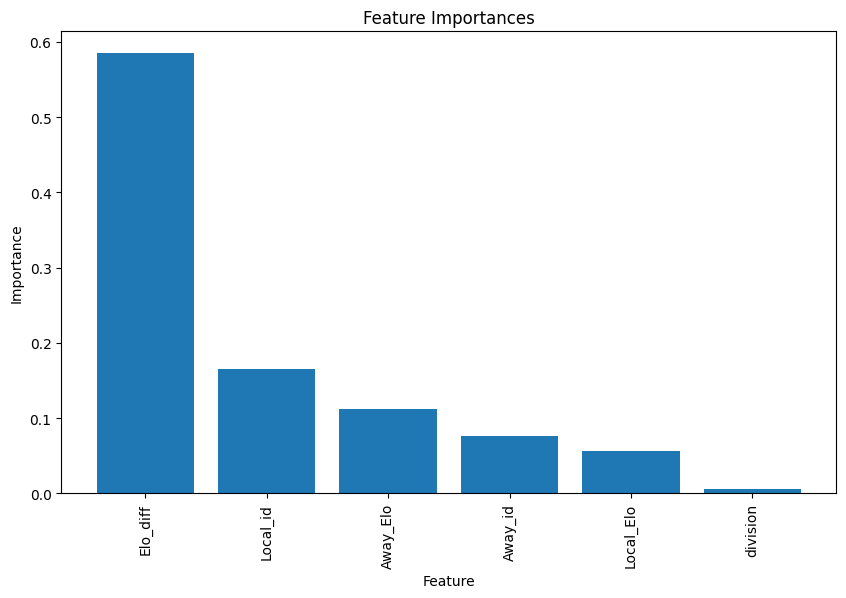

In [6]:
importances = gbm_model.feature_importances_

feature_names = X.columns

indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

When we check which variables the model has used the most to determine the outcome we cas see that the Elo difference between the two teams is the most important. We can conclude that using an Elo score is a reasonable way measure the strenght of a team at a given time. However, being the strongest team is not a guarantee to win at football.

Now we will use this model to make the predictions for season 2021-2022 in matchday 3. We have to prepare the data first.

In [6]:
import sqlite3

conn = sqlite3.connect('../laliga.sqlite') 

query = "SELECT * FROM Predictions;" 

df_sqlite = pd.read_sql_query(query, conn)
selected_columns = ['season', 'division', 'matchday', 'date', 'time', 'home_team', 'away_team','score']
df_predictions = df_sqlite.loc[:, selected_columns]


In [7]:
df_predictions["local_score"] = df_predictions["score"].str.split(":").str[0]
df_predictions["away_score"] = df_predictions["score"].str.split(":").str[1]
df_predictions['results'] = df_predictions.apply(lambda row: 1 if row['local_score'] > row['away_score'] else (2 if row['away_score'] > row['local_score'] else ('X' if row['local_score'] == row['away_score'] else None)), axis=1)
df_predictions['results_encoded'] = df_predictions.apply(lambda row: 1 if row['results'] == 1 else (3 if row['results'] == 2 else (2 if row['results'] == 'X' else None)), axis=1)


df_predictions['local_score'] = df_predictions['local_score'].astype(int)
df_predictions['away_score'] = df_predictions['away_score'].astype(int)
df_predictions['goal_diff'] = df_predictions['local_score'] - df_predictions['away_score']
df_predictions['abs_goal_diff'] = np.abs(train_df['goal_diff'])

In [8]:
Elo_table = pd.read_excel('../data/ELOtable.xlsx')

df_predictions['Local_Elo'] = 0
df_predictions['Away_Elo'] = 0
df_predictions['Elo_diff'] = 0
df_predictions = df_predictions.apply(lambda row: ELO_score(row), axis = 1)

Now that the data is ready we can apply the model over the predictions.

In [12]:
final_pred = gbm_model.predict(df_predictions[features])

final_results_df = df_predictions[features].copy()
final_results_df["y_real"] = df_predictions['results_encoded']
final_results_df["y_pred"] = final_pred.astype(int)
final_results_df

,Local_id,Away_id,Local_Elo,Away_Elo,Elo_diff,division,y_real,y_pred
0,40,1,1149.368635,1119.231116,30.137519,1,1,1
1,11,10,1126.574680,1046.949919,79.624762,1,1,1
2,18,6,1104.560943,1102.326819,2.234125,1,3,1
3,24,44,1133.578834,1125.887327,7.691507,1,1,1
4,39,14,1042.278838,1151.599784,-109.320946,1,2,1
5,12,2,1153.518628,1340.098247,-186.579619,1,3,3
6,5,61,1283.247835,1058.968291,224.279543,1,1,1
7,48,16,1068.675329,1159.239349,-90.564021,1,3,1
8,49,22,1074.563442,1090.916743,-16.353302,1,1,1
9,30,58,1186.422712,1128.449952,57.972760,1,2,1


In [15]:
accuracy = accuracy_score(df_predictions['results_encoded'], final_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6000


The accuracy of the model for the prediction data is 60% for matchday 3 of season 2021-2022.